In [50]:
'''
Way to load mat file in python
Using scipy library
'''

'\nWay to load mat file in python\nUsing scipy library\n'

In [51]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

In [52]:
umist = loadmat('data/umist_cropped.mat')
umist.keys()

dict_keys(['__header__', '__version__', '__globals__', 'facedat', 'dirnames'])

In [53]:
dataset = umist['facedat']

In [54]:
print(f'data.shape: {dataset.shape}')
print(f'data[0].shape: {dataset[0].shape}')
print(f'data[0][0].shape: {dataset[0][0].shape}')

data.shape: (1, 20)
data[0].shape: (20,)
data[0][0].shape: (112, 92, 38)


In [55]:
'''
First understand the shape of the dataset:
The dataset contains 1 x 20 which is a list of 20 sub-arrays
20 sub-arrays may be 20 different persons
Each image is 112x92 pixels
112 is the height of the image
92 is the width of the image

Shape of 1 person: 112 x 92 x n_images
'''

'\nFirst understand the shape of the dataset:\nThe dataset contains 1 x 20 which is a list of 20 sub-arrays\n20 sub-arrays may be 20 different persons\nEach image is 112x92 pixels\n112 is the height of the image\n92 is the width of the image\n\nShape of 1 person: 112 x 92 x n_images\n'

In [56]:
# Combine all the images of all the persons into a single list
data_lst = []

for i in range(20):
    person_imgs = dataset[0][i]
    for j in range(person_imgs.shape[2]):
        img = person_imgs[:, :, j]
        img_flat = img.flatten()
        data_lst.append(np.append(img_flat, i))

In [57]:
# Convert into DataFrame
df_columns = [f'pixel_{i}' for i in range(112*92)] + ['label']
df = pd.DataFrame(data_lst, columns=df_columns)
df.head(5)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_10295,pixel_10296,pixel_10297,pixel_10298,pixel_10299,pixel_10300,pixel_10301,pixel_10302,pixel_10303,label
0,233,234,234,233,234,232,232,168,99,78,...,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,...,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,...,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,...,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,...,176,170,164,162,157,152,150,148,148,0


In [58]:
# Convert into numpy array
data = df.to_numpy()

In [59]:
data.shape

(575, 10305)

In [60]:
X = data[:, :-1]
y = data[:, -1]
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (575, 10304)
y.shape: (575,)


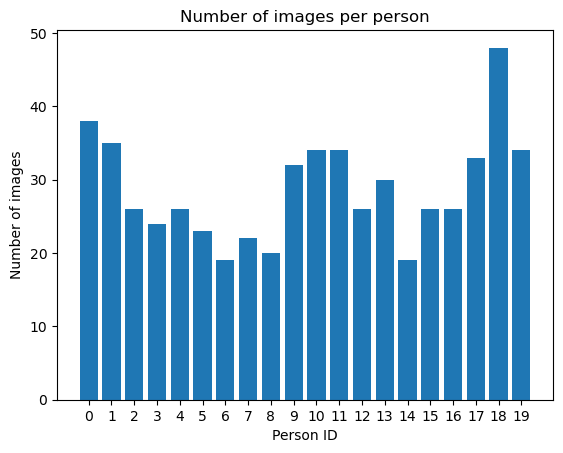

In [61]:
unique_faces, counts = np.unique(y, return_counts=True)

plt.bar(unique_faces, counts)
plt.xlabel('Person ID') 
plt.ylabel('Number of images')
plt.title('Number of images per person')
plt.xticks(ticks=unique_faces.astype(int))
plt.show()

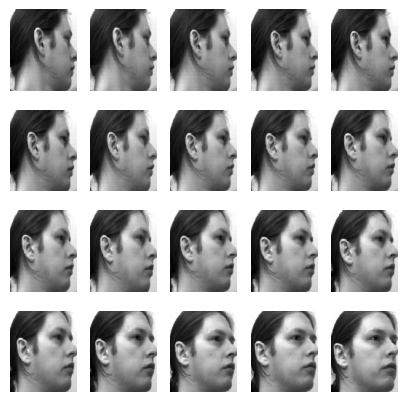

In [62]:
# Plot first person
fig, ax = plt.subplots(4, 5, figsize=(5, 5))
for i in range(20):
    ax[i//5, i%5].imshow(X[i].reshape(112, 92), cmap='gray')
    ax[i//5, i%5].axis('off')
plt.show()

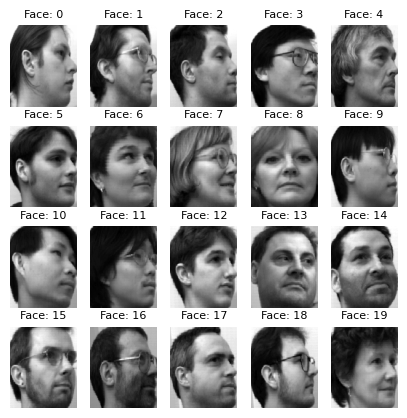

In [63]:
# Plot all unique faces
fig, ax = plt.subplots(4, 5, figsize=(5, 5))
for i in range(20):
    ax[i//5, i%5].imshow(X[y==i][10].reshape(112, 92), cmap='gray')
    ax[i//5, i%5].set_title(f'Face: {i}', fontsize=8)
    ax[i//5, i%5].axis('off')
plt.show()

In [64]:
exploration_scaler = MinMaxScaler()
exploration_pca = PCA(n_components=2, random_state=123)
exploration_pipeline = Pipeline([
    ('scaler', exploration_scaler),
    ('pca', exploration_pca)
])

explored_X = exploration_pipeline.fit_transform(X)

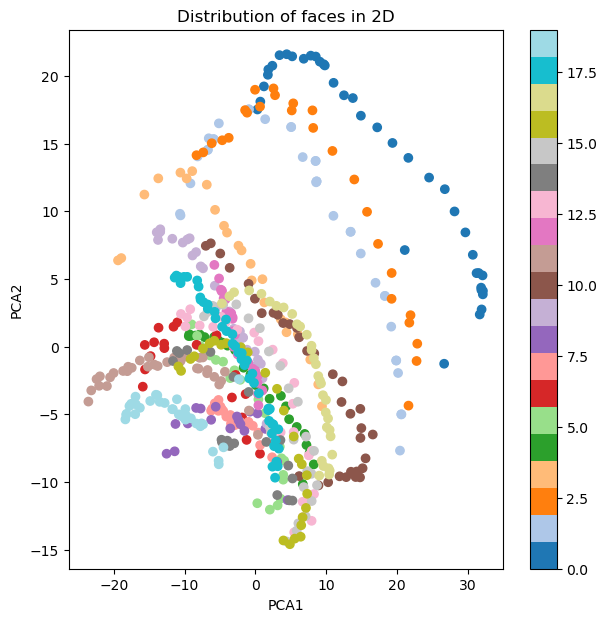

In [65]:
# Plot the distribution of faces in 2D with their labels

plt.figure(figsize=(7, 7))
plt.scatter(explored_X[:, 0], explored_X[:, 1], c=y, cmap='tab20')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Distribution of faces in 2D')
plt.colorbar()
plt.show()

In [66]:
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

Number of duplicate rows: 10


In [67]:
# Remove duplicate rows
df = df.drop_duplicates()

In [68]:
# Dataset is imbalanced, use StratifiedShuffleSplit to split the dataset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=123)
for train_idx, val_test_idx in sss.split(X, y):
    X_train, X_val_test = X[train_idx], X[val_test_idx]
    y_train, y_val_test = y[train_idx], y[val_test_idx]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)
for val_idx, test_idx in sss.split(X_val_test, y_val_test):
    X_val, X_test = X_val_test[val_idx], X_val_test[test_idx]
    y_val, y_test = y_val_test[val_idx], y_val_test[test_idx]

X_train.shape: (345, 10304)
X_val.shape: (115, 10304)
X_test.shape: (115, 10304)


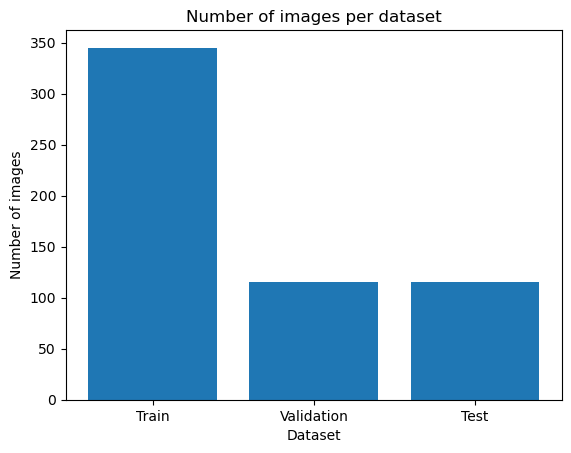

In [69]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'X_test.shape: {X_test.shape}')

x_axis = ['Train', 'Validation', 'Test']
y_axis = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]

plt.bar(x_axis, y_axis)
plt.xlabel('Dataset')
plt.ylabel('Number of images')
plt.title('Number of images per dataset')
plt.show()

In [70]:
df_val = pd.DataFrame(X_val, columns=df_columns[:-1])
df_test = pd.DataFrame(X_test, columns=df_columns[:-1])

# Save the validation and test dataset as csv
df_val.to_csv('data/validation_data/umist_val.csv', index=False)
df_test.to_csv('data/test_data/umist_test.csv', index=False)

In [71]:
unique_faces, train_counts = np.unique(y_train, return_counts=True)
print('Train')
for face, count in zip(unique_faces, train_counts):
    print(f'Face: {face}, Count: {count}')
    
unique_faces, val_counts = np.unique(y_val, return_counts=True)
print('Val')
for face, count in zip(unique_faces, val_counts):
    print(f'Face: {face}, Count: {count}')
    
unique_faces, test_counts = np.unique(y_test, return_counts=True)
print('Test')
for face, count in zip(unique_faces, test_counts):
    print(f'Face: {face}, Count: {count}')

Train
Face: 0, Count: 23
Face: 1, Count: 21
Face: 2, Count: 16
Face: 3, Count: 14
Face: 4, Count: 16
Face: 5, Count: 14
Face: 6, Count: 11
Face: 7, Count: 13
Face: 8, Count: 12
Face: 9, Count: 19
Face: 10, Count: 20
Face: 11, Count: 20
Face: 12, Count: 16
Face: 13, Count: 18
Face: 14, Count: 11
Face: 15, Count: 16
Face: 16, Count: 16
Face: 17, Count: 20
Face: 18, Count: 29
Face: 19, Count: 20
Val
Face: 0, Count: 7
Face: 1, Count: 7
Face: 2, Count: 5
Face: 3, Count: 5
Face: 4, Count: 5
Face: 5, Count: 5
Face: 6, Count: 4
Face: 7, Count: 4
Face: 8, Count: 4
Face: 9, Count: 7
Face: 10, Count: 7
Face: 11, Count: 7
Face: 12, Count: 5
Face: 13, Count: 6
Face: 14, Count: 4
Face: 15, Count: 5
Face: 16, Count: 5
Face: 17, Count: 7
Face: 18, Count: 9
Face: 19, Count: 7
Test
Face: 0, Count: 8
Face: 1, Count: 7
Face: 2, Count: 5
Face: 3, Count: 5
Face: 4, Count: 5
Face: 5, Count: 4
Face: 6, Count: 4
Face: 7, Count: 5
Face: 8, Count: 4
Face: 9, Count: 6
Face: 10, Count: 7
Face: 11, Count: 7
Face: 1

In [72]:
X_train.shape

(345, 10304)

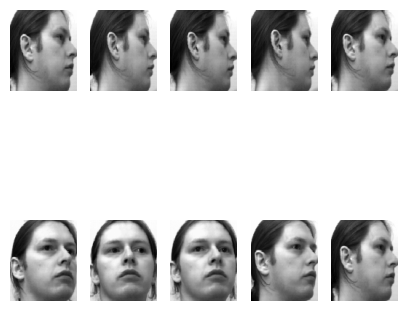

In [73]:
fig, ax = plt.subplots(2, 5, figsize=(5, 5))

for i in range(10):
    ax[i//5, i%5].imshow(X_train[y_train==0][i].reshape(112, 92), cmap='gray')
    ax[i//5, i%5].axis('off')
plt.show()

In [74]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([23, 21, 16, 14, 16, 14, 11, 13, 12, 19, 20, 20, 16, 18, 11, 16, 16,
        20, 29, 20], dtype=int64))

### Figure out some techniques to balance the dataset

In [75]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
)

In [76]:
# Maximum number of images of any class that can be generated
unique_faces, counts = np.unique(y_train, return_counts=True)
max_count = np.max(counts)
max_count

29

In [77]:
augmented_images = []
labels = []


# Loop through each person in the training set and augment images if needed
for person_idx in range(20):
    images = X_train[y_train==person_idx]
    images = images.reshape(-1, 112, 92, 1)
    
    augmented_images.extend(images)
    labels.extend([person_idx]*images.shape[0])
    
    count = images.shape[0]
    
    n_images = max_count - count + 1
    
    if n_images > 0:
        datagen.fit(images)
        
        generated_images = []
        
        for X_batch, y_batch in datagen.flow(images, [0]*count, batch_size=1):
            generated_images.append(X_batch[0])
            
            if len(generated_images) == n_images:
                break
            
        augmented_images.extend(generated_images)
        labels.extend([person_idx]*n_images)
    

In [78]:
# Convert lists to numpy arrays for further use
augmented_images = np.array(augmented_images)
labels = np.array(labels)

print(f'augmented_images.shape: {augmented_images.shape}')

# Check if the set is balanced
unique_faces, counts = np.unique(labels, return_counts=True)
for face, count in zip(unique_faces, counts):
    print(f'Face: {face}, Count: {count}')


augmented_images.shape: (600, 112, 92, 1)
Face: 0, Count: 30
Face: 1, Count: 30
Face: 2, Count: 30
Face: 3, Count: 30
Face: 4, Count: 30
Face: 5, Count: 30
Face: 6, Count: 30
Face: 7, Count: 30
Face: 8, Count: 30
Face: 9, Count: 30
Face: 10, Count: 30
Face: 11, Count: 30
Face: 12, Count: 30
Face: 13, Count: 30
Face: 14, Count: 30
Face: 15, Count: 30
Face: 16, Count: 30
Face: 17, Count: 30
Face: 18, Count: 30
Face: 19, Count: 30


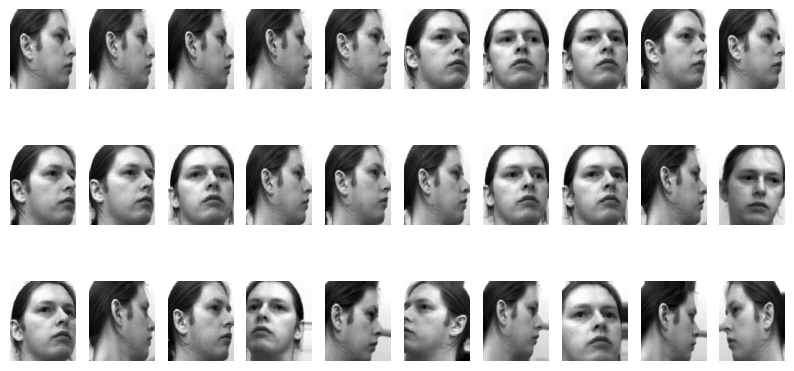

In [79]:
fig, ax = plt.subplots(3, 10, figsize=(10, 5))
for i in range(30):
    ax[i//10, i%10].imshow(augmented_images[i].reshape(112, 92), cmap='gray')
    ax[i//10, i%10].axis('off')
plt.show()

In [80]:
def check_duplicates(images):
    duplicates_found = False
    if duplicates_found == False:
        print("No duplicates found")
        return duplicates_found
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            if np.array_equal(images[i], images[j]):
                duplicates_found = True
                print(f"Duplicate found between indices {i} and {j}")
    return duplicates_found

In [81]:
duplicates_found = check_duplicates(augmented_images)

No duplicates found


In [82]:
while duplicates_found:
    print("Removing duplicates")
    unique_img, unique_idx = np.unique(augmented_images, axis=0, return_index=True)

    # Keep only unique images
    augmented_images = augmented_images[unique_idx]
    labels = labels[unique_idx]
    
    # Re-balance the dataset
    for i in range(20):
        images = augmented_images[labels == i]
        count = images.shape[0]
        
        # Check maximum number of images
        max_count = np.max(counts)
        
        # If the number of images is less than the maximum count, generate more images equal to the maximum count
        if count < max_count:
            n_images = max_count - count
            datagen.fit(images)
            
            
            generated_images = []
            
            for X_batch, y_batch in datagen.flow(images, [0]*count, batch_size=1):
                generated_images.append(X_batch[0])
                
                if len(generated_images) == n_images:
                    break
                
            augmented_images = np.vstack([augmented_images, np.array(generated_images)])
            labels = np.hstack([labels, [i]*n_images])
            
    duplicates_found = check_duplicates(augmented_images)  

In [83]:
df_augmented = pd.DataFrame(augmented_images.reshape(-1, 112*92), columns=df_columns[:-1])
df_augmented['label'] = labels

In [84]:
# Save the augmented dataset with original face id for further use
df_augmented.to_csv('data/umist_with_original_face_id.csv', index=False)

In [85]:
umist_to_csv = pd.DataFrame(augmented_images.reshape(augmented_images.shape[0], -1), columns=[f'pixel_{i}' for i in range(112*92)])
umist_to_csv.to_csv('data/umist_cropped.csv', index=False)